# Explore 3D Array Performance

Explore performance using 3D arrays: https://github.com/sbailey/gpu_specter/issues/17

 * np.linalg.solve
 * ~np.linalg.eigh~ (cupy version is limited to 2D)

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import cupy as cp

## ex2d_patch: np.linalg.solve

### Generate sample data arrays

Problem size for a single patch is nspec*nwave

In [2]:
# nspec_values = (1, 5, 25)
nspec_values = (1, 5)
nwave_values = (30, 40, 50)
grid_nspec, grid_nwave = np.meshgrid(nspec_values, nwave_values)

# typical_problem_sizes
n_values = sorted([
    nspec * nwave for nspec, nwave in zip(grid_nspec.flatten(), grid_nwave.flatten())
])
print("Typical problem sizes:")
print(n_values)

Number of patches depends on the number of spectra and the number wavelengths

Num patches per problem size:
[41666, 31250, 25000, 8333, 6250, 5000]


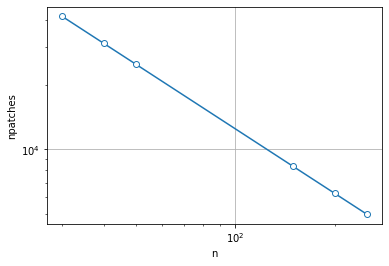

In [30]:
nwave_per_frame = 2500
nspec_per_frame = 500

npatches_values = list(map(lambda x: (nwave_per_frame * nspec_per_frame) // x, n_values))
print("Num patches per problem size:")
print(npatches_values)

plt.plot(n_values, npatches_values, marker='o', mfc='white')
plt.ylabel('npatches')
plt.xlabel('n')
plt.yscale('log')
plt.xscale('log')
plt.grid(True);

In [3]:
np.array(n_values) * np.array(npatches_values)

array([1249980, 1250000, 1250000, 1249950, 1250000, 1250000])

### generate sample data sets

In [4]:
def generate_sample_data(n, m):
    """Generates sample dataset for use with np.linalg.solve
    
    Args:
        n: size of problem
        m: number of patches
    
    Returns:
        a: (m, n, n) 
        b: (m, n)
    """
    
    from numpy.random import default_rng
    rng = default_rng()
    
    # identity matrix + random noise
    i = np.arange(n)
    a = np.zeros((m, n, n))
    a[:, i, i] = 1
    a += (1/n)*rng.standard_normal((m, n, n))

    b = (np.arange(n).reshape(1, n) + np.arange(m).reshape(m, 1))
    b = np.mod(b, n) / np.linalg.norm(np.arange(n))
    
    return a, b

In [5]:
def test_generate_sample_data():
    n, m = 3, 4
    a, b = generate_sample_data(n, m)
    assert a.shape == (m, n, n)
    assert b.shape == (m, n)

test_generate_sample_data()

In [6]:
%%time
a, b = generate_sample_data(250, 5000)

CPU times: user 4.72 s, sys: 822 ms, total: 5.55 s
Wall time: 5.54 s


In [7]:
a.shape, a.dtype, b.shape, b.dtype

((5000, 250, 250), dtype('float64'), (5000, 250), dtype('float64'))

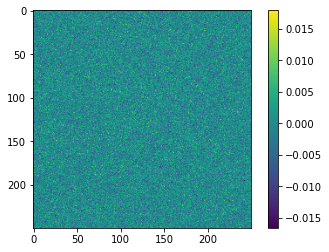

In [8]:
# inspect the sample data set
image = plt.imshow(a[0] - np.identity(a.shape[-1]))
plt.colorbar()

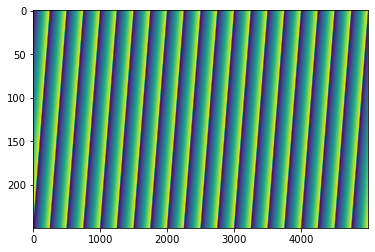

In [9]:
plt.imshow(b.T, aspect="auto")

In [10]:
x = np.linalg.solve(a, b)

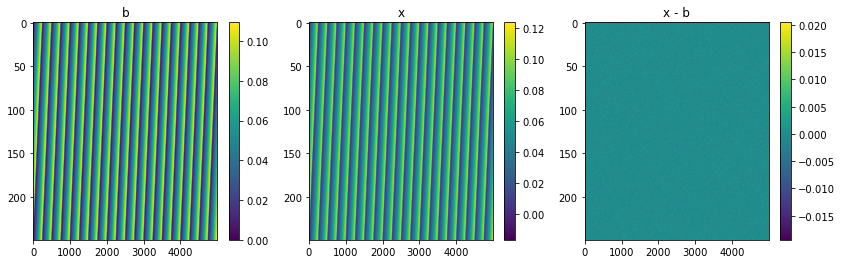

In [11]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 4))

ax = axes[0]
ax.set_title("b")
image = ax.imshow(b.T, aspect="auto")
fig.colorbar(image, ax=ax)

ax = axes[1]
ax.set_title("x")
image = ax.imshow(x.T, aspect="auto")
fig.colorbar(image, ax=ax)

ax = axes[2]
ax.set_title("x - b")
image = ax.imshow((x - b).T, aspect=("auto"))
fig.colorbar(image, ax=ax)

In [12]:
%%time
benchmarks = list()
for n, npatches in zip(n_values, npatches_values):
    
    sample_start = time.time()
    a, b = generate_sample_data(n, npatches)
    sample_end = time.time()
    print(
        f'Generated sample ({a.nbytes / 1024**3:.1f} GB) for '
        f'({n}, {npatches}) in {sample_end-sample_start:.1f} sec'
    )    
    benchmarks.append( (n, npatches, a, b) )

Generated sample (0.3 GB) for (30, 41666) in 0.7 sec
Generated sample (0.4 GB) for (40, 31250) in 0.9 sec
Generated sample (0.5 GB) for (50, 25000) in 1.1 sec
Generated sample (1.4 GB) for (150, 8333) in 3.3 sec
Generated sample (1.9 GB) for (200, 6250) in 4.4 sec
Generated sample (2.3 GB) for (250, 5000) in 6.0 sec
CPU times: user 13.6 s, sys: 2.58 s, total: 16.2 s
Wall time: 16.5 s


### functions to benchmark 

In [13]:
def timer(func):
    def wrapper(*args, **kwargs):
        time_start = time.time()
        
        result = func(*args, **kwargs)
        
        time_end = time.time()
        elapsed_time = time_end - time_start
        return elapsed_time, result
    return wrapper

In [14]:
@timer
def test_timer(n):
    time.sleep(n)
    return n

In [15]:
test_timer(0.1)

(0.10016894340515137, 0.1)

In [16]:
@timer
def process_frame_2d(a, b, x):
    xp = cp.get_array_module(a)
    assert xp == cp.get_array_module(b)
    assert xp == cp.get_array_module(x)
    
    # Iterate over patches and call linalg.solve on each 2d patch
    for i in range(a.shape[0]):
        x[i] = xp.linalg.solve(a[i], b[i])


In [17]:
@timer
def process_frame_3d(a, b, x):
    xp = cp.get_array_module(a)
    assert xp == cp.get_array_module(b)
    assert xp == cp.get_array_module(x)

    # Call linalg.solve with 3d input
    x[:] = xp.linalg.solve(a, b)

    return None

In [18]:
def test_process_frame():
    n, m = 5, 10
    a, b = generate_sample_data(n, m)
    
    result_2d = np.empty_like(b)
    result_3d = np.empty_like(b)

    elapsed_time_2d, _ = process_frame_2d(a, b, result_2d)
    elapsed_time_3d, _ = process_frame_3d(a, b, result_3d)
    
    assert result_2d.shape == (m, n)
    assert result_3d.shape == (m, n)
    
    assert(np.allclose(result_2d, result_3d))

In [19]:
test_process_frame()

### benchmark cpu (numpy)

In [20]:
%%time

nruns = 5
nbenchmarks = len(benchmarks)

elapsed_time_cpu_2d = np.zeros((nruns, nbenchmarks))
elapsed_time_cpu_3d = np.zeros((nruns, nbenchmarks))

print("(n, npatches) [irun/nruns]: elapsed_time_2d, elapsed_time_3d")

for ibenchmark, (n, npatches, a_cpu, b_cpu) in enumerate(benchmarks):
    
    result_2d = np.empty_like(b_cpu)
    result_3d = np.empty_like(b_cpu)
    
    for irun in range(nruns):
        time_2d, _ = process_frame_2d(a_cpu, b_cpu, result_2d)
        elapsed_time_cpu_2d[irun, ibenchmark] = time_2d

        time_3d, _ = process_frame_3d(a_cpu, b_cpu, result_3d)
        elapsed_time_cpu_3d[irun, ibenchmark] = time_3d

        if irun == 0:
            print(f"({n}, {npatches}) [{irun}/{nruns}]: {time_2d:.1f}, {time_3d:.1f}")

(n, npatches) [irun/nruns]: elapsed_time_2d, elapsed_time_3d
(30, 41666) [0/5]: 1.3, 0.6
(40, 31250) [0/5]: 1.9, 0.8
(50, 25000) [0/5]: 1.1, 0.9
(150, 8333) [0/5]: 2.9, 2.6
(200, 6250) [0/5]: 3.0, 2.8
(250, 5000) [0/5]: 4.7, 4.5
CPU times: user 4min 14s, sys: 806 ms, total: 4min 15s
Wall time: 2min 8s


In [34]:
def plot_benchmark_results(benchmarks, elapsed_time_2d, elapsed_time_3d, cpu_or_gpu='CPU', ax=None):
    
    def get_stats(elapsed_time):
        return np.mean(elapsed_time, axis=0), np.std(elapsed_time, axis=0)

    avg_2d, std_2d = get_stats(elapsed_time_2d)
    avg_3d, std_3d = get_stats(elapsed_time_3d)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    labels = [f'({n}, {npatches})' for n, npatches, a, b in benchmarks]
    # ticks = np.array([n for n, _, _, _ in benchmarks])
    ticks = np.arange(len(labels))
    tick_offset = 0.05

    ax.errorbar(ticks - tick_offset, avg_2d, std_2d, marker='o', ls='', label=f'{cpu_or_gpu} 2D')
    ax.errorbar(ticks + tick_offset, avg_3d, std_3d, marker='o', ls='', label=f'{cpu_or_gpu} 3D')

    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel("Benchmark (nwave*nspectra, npatches)")

    ax.set_ylabel("Runtime (Seconds)")
    ax.set_yscale("log")
    ax.legend()
    ax.grid(True);

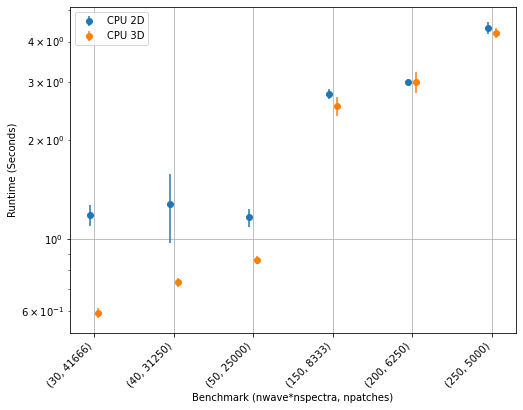

In [35]:
plot_benchmark_results(benchmarks, elapsed_time_cpu_2d, elapsed_time_cpu_3d, 'CPU')

### benchmark gpu (cupy)

In [23]:
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

In [24]:
mempool.get_limit()

0

In [25]:
print(mempool.used_bytes(), mempool.total_bytes())

0 0


In [26]:
# for n, npatches, a, b in benchmarks[::-1]:
#     @timer
#     def transfer(a_cpu):
#         print(' ', mempool.used_bytes(), mempool.total_bytes(), mempool.n_free_blocks())
#         a_gpu = cp.array(a_cpu)
#         print(' ', mempool.used_bytes(), mempool.total_bytes(), mempool.n_free_blocks())
#         a_gpu = None
#         mempool.free_all_blocks()
#         pinned_mempool.free_all_blocks()
#     print(n, npatches, a.shape, a.nbytes)
#     elapsed_time, _ = transfer(a)
#     print(f'{elapsed_time:.1f} sec')
# print(mempool.used_bytes(), mempool.total_bytes())

In [27]:
# how does mempool work?

# x_cpu = np.ndarray(100)
# print(x_cpu.nbytes)

# print(mempool.used_bytes(), mempool.total_bytes(), mempool.n_free_blocks())
# x_gpu = cp.array(x_cpu)
# print(mempool.used_bytes(), mempool.total_bytes(), mempool.n_free_blocks())

# mempool.free_all_blocks()
# print(mempool.used_bytes(), mempool.total_bytes(), mempool.n_free_blocks())

# x_gpu = None
# print(mempool.used_bytes(), mempool.total_bytes(), mempool.n_free_blocks())

# mempool.free_all_blocks()
# print(mempool.used_bytes(), mempool.total_bytes(), mempool.n_free_blocks())

In [28]:
%%time

nruns = 5
nbenchmarks = len(benchmarks)

elapsed_time_gpu_2d = np.zeros((nruns, nbenchmarks))
elapsed_time_gpu_3d = np.zeros((nruns, nbenchmarks))

print("(n, npatches) [irun/nruns]: elapsed_time_2d, elapsed_time_3d")

for ibenchmark, (n, npatches, a_cpu, b_cpu) in enumerate(benchmarks[::-1]):
    # running in reverse order to detect issue with gpu memory early
    ibenchmark = nbenchmarks - ibenchmark - 1
    
    # gpu extras
    a_gpu = cp.array(a_cpu)
    b_gpu = cp.array(b_cpu)
    
    result_2d = cp.empty_like(b_gpu)
    result_3d = cp.empty_like(b_gpu)
    
    for irun in range(nruns):
        time_2d, _ = process_frame_2d(a_gpu, b_gpu, result_2d)
        elapsed_time_gpu_2d[irun, ibenchmark] = time_2d

        time_3d, _ = process_frame_3d(a_gpu, b_gpu, result_3d)
        elapsed_time_gpu_3d[irun, ibenchmark] = time_3d

        print(f"({n}, {npatches}) [{irun}/{nruns}]: {time_2d:.1f}, {time_3d:.1f}")
        
    # gpu extras
    a_gpu = None
    b_gpu = None
    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

(n, npatches) [irun/nruns]: elapsed_time_2d, elapsed_time_3d
(250, 5000) [0/5]: 8.7, 7.2
(250, 5000) [1/5]: 7.2, 7.2
(250, 5000) [2/5]: 7.2, 7.2
(250, 5000) [3/5]: 7.2, 7.2
(250, 5000) [4/5]: 7.2, 7.2
(200, 6250) [0/5]: 6.9, 6.8
(200, 6250) [1/5]: 6.9, 6.8
(200, 6250) [2/5]: 6.9, 6.8
(200, 6250) [3/5]: 6.9, 6.8
(200, 6250) [4/5]: 6.9, 6.8
(150, 8333) [0/5]: 6.9, 6.7
(150, 8333) [1/5]: 6.8, 6.7
(150, 8333) [2/5]: 6.8, 6.7
(150, 8333) [3/5]: 6.8, 6.7
(150, 8333) [4/5]: 6.8, 6.7
(50, 25000) [0/5]: 11.2, 11.2
(50, 25000) [1/5]: 11.2, 11.1
(50, 25000) [2/5]: 11.2, 11.1
(50, 25000) [3/5]: 11.2, 11.2
(50, 25000) [4/5]: 11.2, 11.1
(40, 31250) [0/5]: 10.8, 10.7
(40, 31250) [1/5]: 11.0, 10.7
(40, 31250) [2/5]: 10.8, 10.7
(40, 31250) [3/5]: 10.8, 10.7
(40, 31250) [4/5]: 11.0, 10.7
(30, 41666) [0/5]: 4.8, 4.6
(30, 41666) [1/5]: 4.8, 4.6
(30, 41666) [2/5]: 4.8, 4.6
(30, 41666) [3/5]: 4.8, 4.6
(30, 41666) [4/5]: 4.8, 4.6
CPU times: user 6min 35s, sys: 1min 30s, total: 8min 6s
Wall time: 9min 22s


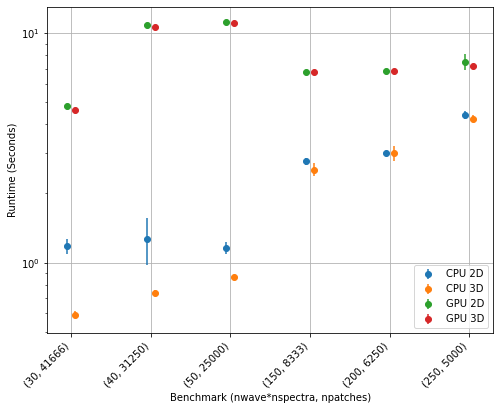

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_benchmark_results(benchmarks, elapsed_time_cpu_2d, elapsed_time_cpu_3d, 'CPU', ax=ax)
plot_benchmark_results(benchmarks, elapsed_time_gpu_2d, elapsed_time_gpu_3d, 'GPU', ax=ax)